<a href="https://colab.research.google.com/github/juansojo24/Chest_X-ray_project/blob/main/Chest_X_Ray_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Downloadinig the dataset:
!wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip

--2021-11-23 22:24:14--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2021-11-23 22:24:14--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd3348c2fd8f0dbddc0eb3b01a5.dl.dropboxusercontent.com/cd/0/inline/BaiQGXU66gHmJE2Mp6sVIvsSu3Sxu1B2Uq4G2gu_o2SkfaZroT0vpK7fmeL_CxmwUEGyLpZDrardoaMJuTVU4KMmomrdj1ttwSktpcXrIgEr2M6RziusSd9ZQhmPfkGaWpo_tmctp5sb0YVvCbn_JOAJ/file# [following]
--2021-11-23 22:24:15--  https://ucd3348c2fd8f0dbddc0eb3b01a5.dl.dropboxusercontent.com/cd/0/inline/BaiQGXU66gHmJE2Mp6sVIvsSu3Sxu1B2Uq4G2gu_o2SkfaZroT0vpK7fmeL_CxmwUEGyLpZDrardoaMJuTVU4KMmomrdj

In [2]:
# Unzipping the data:
!unzip -q "archive.zip"

In [3]:
# Imports required for this projects
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [4]:
# Creating the pathlib PATH objects:
train_path = Path("chest_xray/train/")
validation_path = Path("chest_xray/test")
test_path = Path("chest_xray/val")

In [5]:
# Collecting all the paths inside "Normal" and "Pneumonia" folders of the above paths
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

# Output is a generator object:
print(train_image_paths)


<generator object Path.glob at 0x7f77989368d0>


In [6]:
# Convert Generator Object to List of elements

train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Now the outputs are "PosixPath" objects
print(train_image_paths[:3])

[PosixPath('chest_xray/train/NORMAL/IM-0384-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-1347-0001.jpeg'), PosixPath('chest_xray/train/NORMAL/NORMAL2-IM-0564-0001.jpeg')]


In [7]:
# Convert Posix paths to normal strings
train_image_paths = list(map(lambda x: str(x),train_image_paths))
val_image_paths = list(map(lambda x : str(x),val_image_paths))

print(train_image_paths[:3])

['chest_xray/train/NORMAL/IM-0384-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-1347-0001.jpeg', 'chest_xray/train/NORMAL/NORMAL2-IM-0564-0001.jpeg']


In [8]:
# Collect Length for Training and Validation Datasets

train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

In [9]:
# Every Image has Label in its path, so let's slice it

LABELS = {'NORMAL': 0,'PNEUMONIA': 1}
INV_LABELS = {0:'NORMAL',1:'PNEUMONIA'}

def get_label(path : str) -> int:
  return LABELS[path.split('/')[-2]]

train_labels = list(map(lambda x: get_label(x),train_image_paths))
val_labels = list(map(lambda x: get_label(x),val_image_paths))

print(train_labels[:3])

[0, 0, 0]


In [10]:
# Now we have all training, validation image paths and theri respective lables

BATCH_SIZE = 32

# Function used for Transformation

def load_and_transform(image,label, train = True):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image,[224 ,224],method="nearest")
  if train:
    image = tf.image.random_flip_left_right(image)
  return image,label

In [11]:
# Function used to create a Tensorflow Data Object

def get_dataset(paths,labels, train = True):
  image_paths = tf.convert_to_tensor(paths)
  labels = tf.convert_to_tensor(labels)

  image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
  label_dataset = tf.data.Dataset.from_tensor_slices(labels)

  dataset = tf.data.Dataset.zip((image_dataset,label_dataset)).shuffle(1000)

  dataset = dataset.map(lambda image,label : load_and_transform(image,label,train))
  dataset = dataset.repeat()
  dataset = dataset.shuffle(2048)
  dataset = dataset.batch(BATCH_SIZE)

  return dataset

In [12]:
# Creating Train Dataset object and verifying it

%time train_dataset = get_dataset(train_image_paths,train_labels)

image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)


CPU times: user 579 ms, sys: 359 ms, total: 938 ms
Wall time: 3.19 s
(32, 224, 224, 3)
(32,)


PNEUMONIA


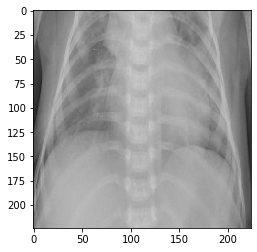

In [13]:
# View a sample Train Image

print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [14]:
%time val_dataset = get_dataset(val_image_paths,val_labels, train = False)

image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 23.2 ms, sys: 0 ns, total: 23.2 ms
Wall time: 25.5 ms
(32, 224, 224, 3)
(32,)


In [15]:
# Building ResNet50 model
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape = (224, 224, 3),
    include_top = False
)

model = tf.keras.Sequential([
                             backbone,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             tf.keras.layers.Dense(1,activation = 'sigmoid')
])

model.summary()

94683136/94668760 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 23,521,409
Non-trainable params: 45,440
_________________________________________________________________


In [16]:
# Compiling your model by providing the optimizer, loss and metrics

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9,beta_2=0.999,epsilon=1e-07),
    loss = 'binary_crossentropy',
    metrics = ['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

In [17]:
# Defining our Callbacks

checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose = 1,save_best_only=True,save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)


In [18]:
# Train the model

history = model.fit(
    train_dataset,
    steps_per_epoch = train_dataset_length//BATCH_SIZE,
    epochs = 8,
    callbacks = [checkpoint,early_stop],
    validation_data = val_dataset,
    validation_steps = val_dataset_length//BATCH_SIZE
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.1803 - accuracy: 0.9373 - precision: 0.9544 - recall: 0.9508
Epoch 00001: val_loss improved from inf to 18.68826, saving model to best_weights.h5
163/163 [==============================] - 194s 952ms/step - loss: 0.1803 - accuracy: 0.9373 - precision: 0.9544 - recall: 0.9508 - val_loss: 18.6883 - val_accuracy: 0.3701 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.0837 - accuracy: 0.9655 - precision: 0.9752 - recall: 0.9782
Epoch 00002: val_loss improved from 18.68826 to 0.31160, saving model to best_weights.h5
163/163 [==============================] - 153s 939ms/step - loss: 0.0837 - accuracy: 0.9655 - precision: 0.9752 - recall: 0.9782 - val_loss: 0.3116 - val_accuracy: 0.8651 - val_precision: 0.8341 - val_recall: 0.9761
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0668 - accuracy: 0.9758 - precision: 0.9842 - re

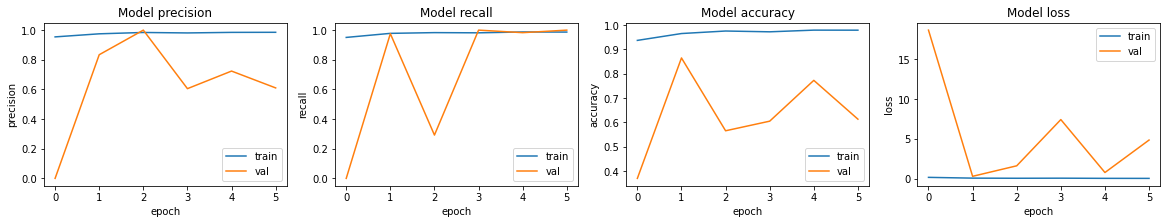

In [19]:
# Interpreting the metrics:

fig, ax = plt.subplots(1,4, figsize = (20, 3))
ax = ax.ravel()

for i,met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
  ax[i].plot(history.history[met])
  ax[i].plot(history.history['val_' + met])
  ax[i].set_title('Model {}'.format(met))
  ax[i].set_xlabel('epoch')
  ax[i].set_ylabel(met)
  ax[i].legend(['train','val'])

In [20]:
# Save the best model

# Load the best weights
model.load_weights("best_weights.h5")
# Save the whole model (weights + architecture)

model.save("model.h5")


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [21]:
# Loading the whole model:

loaded_model = tf.keras.models.load_model("model.h5")

In [24]:
# Evaluating the model on test data:

# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation

test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x: str(x), test_image_paths))
test_labels = list(map(lambda x: get_label(x), test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image,label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image,[224 ,224], method='nearest')
  return image, label

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [25]:
# Verify Test Dataset Object

image, label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


NORMAL


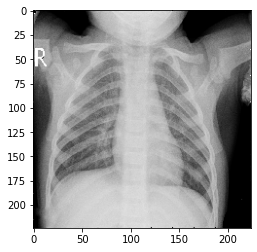

In [26]:
# View a sample Validation Image:

print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224, 224, 3))

In [27]:
# Evaluating the loaded model:

loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : ",acc)
print(" Testing Precision ", prec)
print(" Testing Recall ", rec)

1/1 [==============================] - 3s 3s/step - loss: 0.4108 - accuracy: 0.8125 - precision: 0.7273 - recall: 1.0000
 Testing Acc :  0.8125
 Testing Precision  0.7272727489471436
 Testing Recall  1.0


 More things to try:

 * Medical problem statements are complex and there's a high chance to miss some important point before solving the issue.

 * X-ray scanners made by different companies do post processing in different ways.

 * Changes are huge in pixel level.

 * To improve the existing dataset by collecting X rays from multiple hospitals and different machines.

**Augmentation**

* Augmentation is the tricky part in medical imaging.
*  We cannot use most of the augmentations
* It might change the image itself.
* To use augmentations which do not affect pixel values like horizontal rotations, random image cropping.
* We could also try out Blurring images in a minimal way.

**Callbacks**

* We have used only 2 callbacks.
* We colud use more callbacks like "LRScheduler" or "Reduce on Plateau" or build one custom callback relevant to the problem statement.

**Models**

* Truy other models: We have 'Inception' networks "EfficientNets", "NasNets".
* We need to try out different Models, compare the performance and then move forward with one of them.


